In [1]:
import anndata as ad
import scanpy as sc
import squidpy as sq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import combinations

from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
import statsmodels.api as sm
from statsmodels.formula.api import ols

import seaborn as sns
from scipy.stats import f_oneway

In [2]:
fdata = sc.read_h5ad("./RNA/Multitime.clustered.h5")
# fdata = sc.read_h5ad('./RNA/Multitime.filtered.guide.h5')

In [3]:
gdata = sc.read_h5ad('./RNA/Multitime.filtered.guide.bin100.h5')

In [3]:
# data_list = ["./RNA/B924-1.guide.bin_100.h5", "./RNA/B926-1.guide.bin_100.h5", "./RNA/B922-1.guide.bin_100.h5",
#              "./RNA/B924-2.guide.bin_100.h5", "./RNA/B926-2.guide.bin_100.h5", "./RNA/B922-2.guide.bin_100.h5"]
# marker = ["1-1", "2-1", "3-1", "1-2", "2-2", "3-2"]

In [4]:
# anndata_list = []
# for idx, data in enumerate(data_list):
#     anndata_ = sc.read_h5ad(data)
#     anndata_.obs["marker"] = marker[idx]
#     anndata_list.append(anndata_)
# guide_data = ad.concat(anndata_list, join="outer")
# guide_data.obs_names_make_unique()

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [6]:
def clean_guide_data(rnadata, guidedata):

    rnadata.obs["cov"] = [str(marker) + '_' + str(array[0]) + "-" + str(array[1]) for marker, array in zip(rnadata.obs["marker"], rnadata.obsm["spatial"])]
    guidedata.obs["cov"] = [str(marker) + '_' + str(array[0]) + "-" + str(array[1]) for marker, array in zip(guidedata.obs["marker"], guidedata.obsm["spatial"])]

    common_cov = np.intersect1d(rnadata.obs['cov'], guidedata.obs['cov'])
    guidedata.obs_names = guidedata.obs['cov']
    rnadata.obs_names = rnadata.obs['cov']

    guidedata_filtered = guidedata[common_cov].copy()
    sorted_obs_names = rnadata.obs_names.sort_values()
    guidedata_filtered = guidedata_filtered[sorted_obs_names].copy()
    rnadata = rnadata[sorted_obs_names].copy()
    missing_cov = rnadata.obs['cov'][~rnadata.obs['cov'].isin(common_cov)]
    if len(missing_cov) > 0:
        missing_obs = pd.DataFrame({'marker': [cov.split('_')[0] for cov in missing_cov]}, index=missing_cov)
        missing_obsm_spatial = np.array([[float(cov.split('_')[1].split('-')[0]), float(cov.split('_')[1].split('-')[1])] for cov in missing_cov])
        missing_X = np.zeros((len(missing_cov), guidedata.shape[1]))  # 假设 guidedata 和 rnadata 的 shape[1] 相同

        missing_guidedata = ad.AnnData(X=missing_X, obs=missing_obs, obsm={'spatial': missing_obsm_spatial})
        guidedata_filtered = guidedata_filtered.concatenate(missing_guidedata)
    return rnadata, guidedata_filtered

In [7]:
# fdata, guide_data = clean_guide_data(fdata, guide_data)

In [4]:
gdata.obs.marker = gdata.obs.marker.map({
    'B926-1': '2-1',
    'B926-2': '2-2',
    'B924-1': '1-1',
    'B924-2': '1-2',
    'B922-1': '3-1',
    'B922-2': '3-2'
})

In [8]:
# guide_data[:, 'sgNTC'].X = guide_data[:, ['sgNTC', 'sgnon-targeting_2_gene', 'sgnon-targeting_1_gene']].X.sum(axis=1)

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


In [9]:
# guide_data = guide_data[:, :-2].copy()

In [10]:
# guide_data.write_h5ad("./RNA/Multitime.guide.h5")

In [5]:
fdata.obs['coord_x'] = fdata.obsm['spatial'][:, 0] // 100 * 100
fdata.obs['coord_y'] = fdata.obsm['spatial'][:, 1] // 100 * 100

gdata.obs['coord_x'] = gdata.obsm['spatial'][:, 0] // 100 * 100
gdata.obs['coord_y'] = gdata.obsm['spatial'][:, 1] // 100 * 100
fdata.obs_names = [str(marker) + '_' + str(x) + '_' + str(y) for marker, x, y in zip(fdata.obs['marker'], fdata.obs['coord_x'], fdata.obs['coord_y'])]
gdata.obs_names = [str(marker) + '_' + str(x) + '_' + str(y) for marker, x, y in zip(gdata.obs['marker'], gdata.obs['coord_x'], gdata.obs['coord_y'])]

common_bins = np.intersect1d(fdata.obs_names, gdata.obs_names)
fdata = fdata[common_bins].copy()
gdata = gdata[common_bins].copy()

In [6]:
gdata.obs["cluster"] = fdata.obs["cluster_cellcharter_givenk"].tolist()

In [14]:
gdata.write_h5ad('./RNA/Multitime.filtered.guide.fixed.h5')

In [4]:
gdata = sc.read_h5ad('./RNA/Multitime.filtered.guide.fixed.h5')

In [14]:
gdata = utils.combine_guide_replicates(gdata)

/home/wpy/stereoseq/20240502-SPACseq/bin/utils.py:88: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()


Text(0.5, 1.0, 'KDE of Spp1')

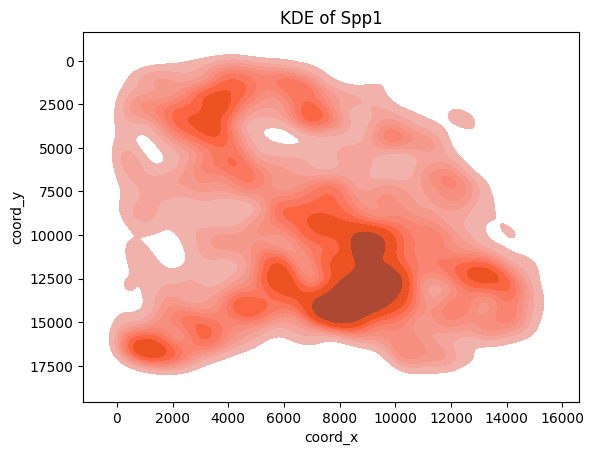

In [36]:
fdata_ = fdata[fdata.obs.marker == '2-1']
fdata_ = fdata_[fdata_[:, 'Spp1'].X > 1]
s_df = pd.DataFrame({
    'coord_x': fdata_.obsm['spatial'][:, 0],
    'coord_y': fdata_.obsm['spatial'][:, 1],
    'hue': [1] * fdata_.shape[0]
})

fig, ax = plt.subplots(1, 1)
# sq.pl.spatial_scatter(fdata_, color='shannon', shape=None, size=0, library_id='spatial', ax=ax)
sns.kdeplot(s_df, x='coord_x', y='coord_y', fill=True, bw_adjust=0.5, ax=ax, alpha=1, hue='hue', palette='Reds', legend=False)
plt.gca().invert_yaxis()
plt.title('KDE of Spp1')

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/plotting/_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/tmp/ipykernel_55916/291812472.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap("jet")


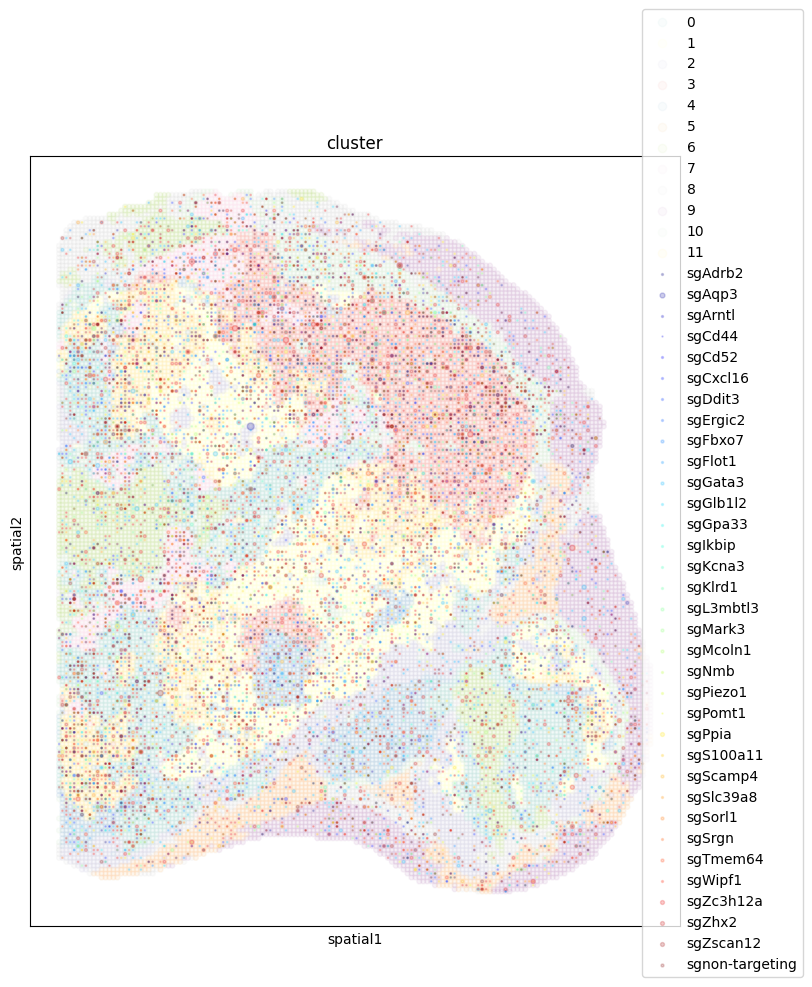

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdata.obs.cluster = gdata.obs.cluster.astype('category')
sq.pl.spatial_scatter(
    gdata[gdata.obs.marker == '2-1'], 
    color=['cluster'], 
    library_key='marker',  
    size=50, 
    img=None,
    spatial_key='spatial',
    palette='Set3',
    figsize=(15, 15),
    ncols=2,
    shape=None,
    ax=ax,
    alpha=0.05
)

from bin import utils
import matplotlib.cm as cm
colormap = cm.get_cmap("jet")
colors = colormap(np.linspace(0, 1, len(gdata.var_names)))
for idx, guide in enumerate(gdata.var_names):
    utils.plot_dot(gdata[gdata.obs.marker == '2-1'], guide, ax=ax, color=colors[idx])
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.2))

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. 

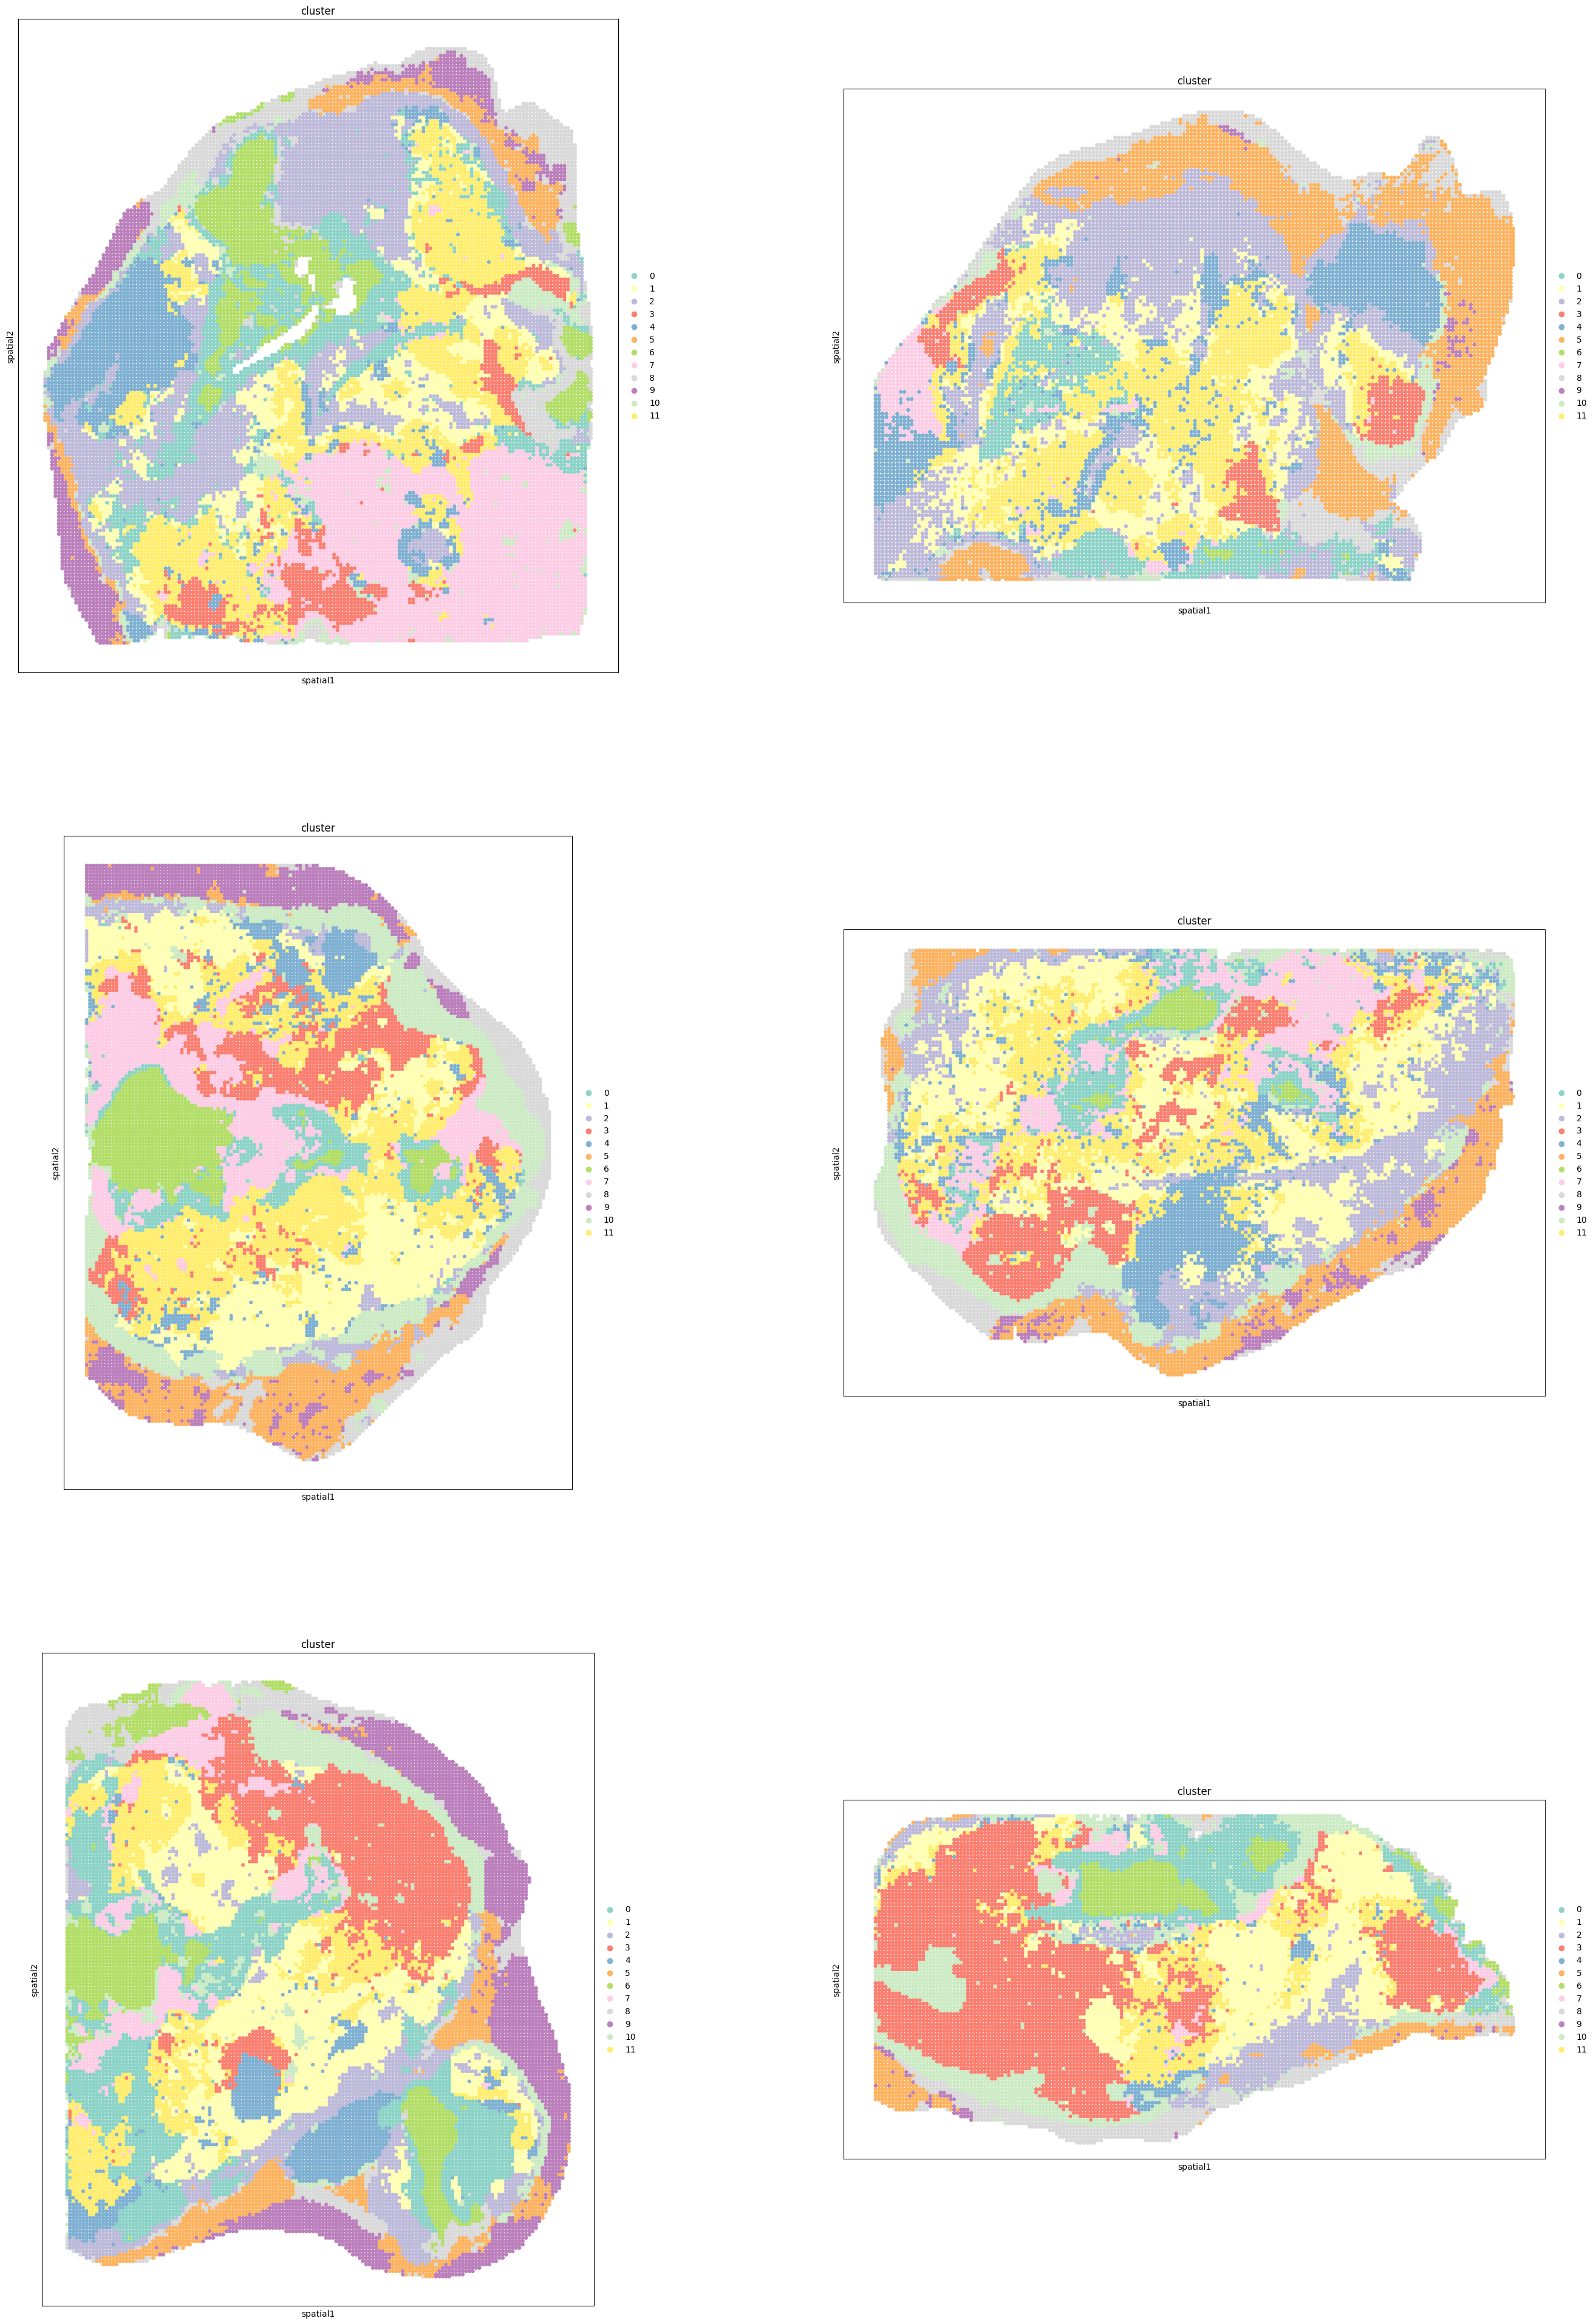

In [15]:
gdata.obs.cluster = gdata.obs.cluster.astype('category')
sq.pl.spatial_scatter(
    gdata, 
    color=['cluster'], 
    library_key='marker',  
    size=50, 
    img=None,
    spatial_key='spatial',
    palette='Set3',
    figsize=(15,15),
    ncols=2,
    shape=None
)

In [4]:
guide_data = gdata.copy()

In [5]:
c_df = pd.DataFrame(guide_data.X.toarray(), columns=guide_data.var_names)
c_df["marker"] = guide_data.obs["marker"].tolist()
c_df["cluster"] = guide_data.obs["cluster"].tolist()
c_df = c_df.groupby(["marker", "cluster"]).sum().unstack()

In [6]:
c_df

sgAdrb2_1_gene                                    ...  \
cluster             0   1  2    3   4   5  6   7  8   9   ...   
marker                                                    ...   
1-1                 11  47  4   27  16  17  6  31  7  16  ...   
1-2                 15  51  6   49  19   4  1  28  4   3  ...   
2-1                 14  15  1   21   5   8  4   4  3  10  ...   
2-2                 14  18  2  185   1   0  0   9  5   0  ...   
3-1                  0   0  0    0   0   0  0   0  0   0  ...   
3-2                  2   3  4    9   7   4  0   3  3   0  ...   

        sgZscan12_2_gene                                        
cluster               2    3   4   5   6   7   8   9   10   11  
marker                                                          
1-1                   13   48  29  30  17  74  10  35  53  123  
1-2                   42   68  68  13   8  80   8   3  38  114  
2-1                    6   50  14   3  12  20  12  17  28   24  
2-2                    2  109   6   2   3   3   6   0  26   22  
3-1                    1    2   1   0   0   6   0   1   2    2  
3-2                    0    0   0   0   0   0   0   0   0    0  

[6 rows x 804 columns]

cluster                 0         1         2         3         4         5   \
sgAdrb2_1_gene    0.133333  0.142857  0.009524  0.200000  0.047619  0.076190   
sgAdrb2_2_gene    0.143939  0.189394  0.053030  0.227273  0.053030  0.037879   
sgAqp3_1_gene     0.117647  0.147059  0.088235  0.191176  0.044118  0.029412   
sgAqp3_2_gene     0.101911  0.101911  0.012739  0.363057  0.038217  0.014862   
sgArntl_1_gene    0.093023  0.186047  0.023256  0.116279  0.081395  0.023256   
...                    ...       ...       ...       ...       ...       ...   
sgZc3h12a_2_gene  0.150619  0.146492  0.035076  0.164374  0.061210  0.028198   
sgZhx2_1_gene     0.127466  0.124431  0.034901  0.197269  0.062215  0.028832   
sgZhx2_2_gene     0.096591  0.153409  0.022727  0.187500  0.068182  0.028409   
sgZscan12_1_gene  0.142222  0.128889  0.057778  0.191111  0.048889  0.022222   
sgZscan12_2_gene  0.145522  0.160448  0.022388  0.186567  0.052239  0.011194   

cluster                 6         7         8         9         10        11  
sgAdrb2_1_gene    0.038095  0.038095  0.028571  0.095238  0.066667  0.123810  
sgAdrb2_2_gene    0.045455  0.045455  0.030303  0.045455  0.030303  0.098485  
sgAqp3_1_gene     0.014706  0.058824  0.000000  0.073529  0.102941  0.132353  
sgAqp3_2_gene     0.033970  0.057325  0.027601  0.055202  0.059448  0.133758  
sgArntl_1_gene    0.046512  0.069767  0.034884  0.058140  0.104651  0.162791  
...                    ...       ...       ...       ...       ...       ...  
sgZc3h12a_2_gene  0.052270  0.066025  0.024759  0.061898  0.070839  0.138239  
sgZhx2_1_gene     0.056146  0.068285  0.013657  0.081942  0.066768  0.138088  
sgZhx2_2_gene     0.045455  0.085227  0.028409  0.071023  0.068182  0.144886  
sgZscan12_1_gene  0.066667  0.031111  0.031111  0.080000  0.035556  0.164444  
sgZscan12_2_gene  0.044776  0.074627  0.044776  0.063433  0.104478  0.089552  

[67 rows x 12 columns]

In [81]:
m_df = c_df.loc['1-2'].unstack()
ntc_cnt = m_df.loc['sgnon-targeting'].sum()
m_df = m_df.div(m_df.sum(axis=1), axis=0) * ntc_cnt
chi_dict = {}
for guide in gdata.var_names:
    if m_df.loc[guide].sum() == 0:
        chi_dict[guide] = 1
        continue
    if guide == 'sgnon-targeting': continue
    chi_dict[guide] = chi2_contingency(m_df.loc[['sgnon-targeting', guide]].T).pvalue

/tmp/ipykernel_67620/4195890638.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(pdf, x='index', y='Chi p-value', palette='RdBu_r')


Text(0.5, 0, 'Guide')

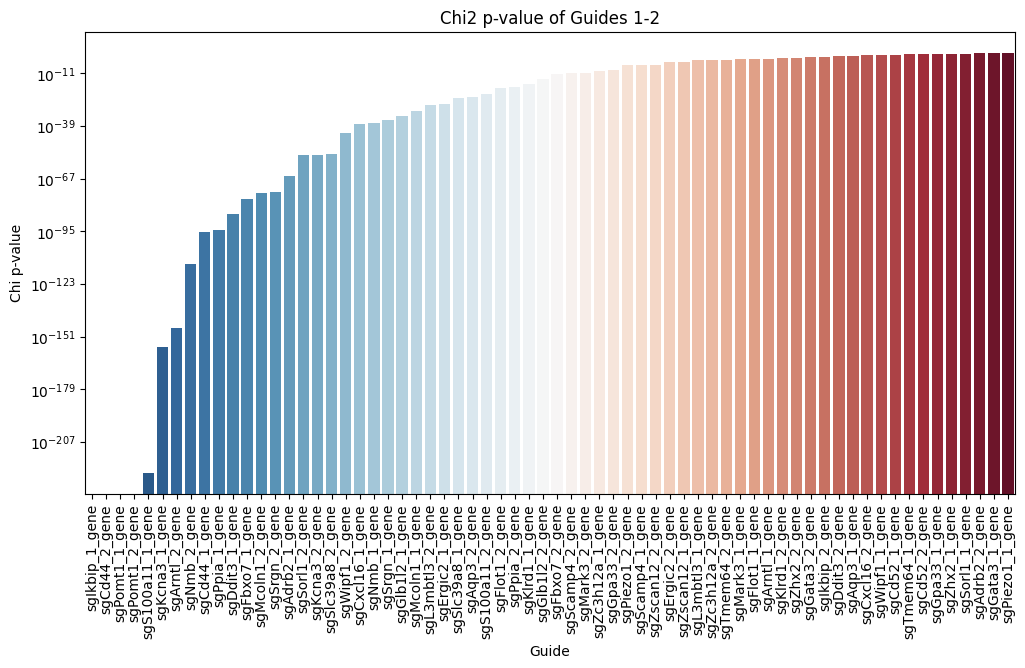

In [83]:
pdf = pd.DataFrame(chi_dict, index=['Chi p-value']).T.sort_values(by='Chi p-value').reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(pdf, x='index', y='Chi p-value', palette='RdBu_r')
plt.xticks(rotation=90)
plt.gca().set_yscale('log')
plt.title('Chi2 p-value of Guides 1-2')
plt.xlabel('Guide')

In [22]:
from scipy.stats import chi2_contingency

In [39]:
p_df = pd.DataFrame()
flag = False
for guide in np.unique(c_df.columns.get_level_values(0)):
    sum_v = c_df[guide].sum(axis=1)
    p_v = (c_df[guide].T / sum_v).T
    if not flag:
        p_df = pd.concat([p_df, p_v.reset_index().melt(id_vars="marker")], axis=1)
        flag = True
    else: p_df = pd.concat([p_df, p_v.reset_index().melt(id_vars="marker").value], axis=1)
pp_df = p_df.iloc[:, 2:]
pp_df.columns = np.unique(c_df.columns.get_level_values(0))
pp_df.index = [str(marker) + "_" + str(cluster) for marker, cluster in zip(p_df["marker"], p_df["cluster"])]

In [11]:
pp_df.fillna(0, inplace=True)

/tmp/ipykernel_55568/2672146510.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(df, x='index', y='Shannon Entropy', palette='RdBu_r')


Text(0.5, 0, 'Guide')

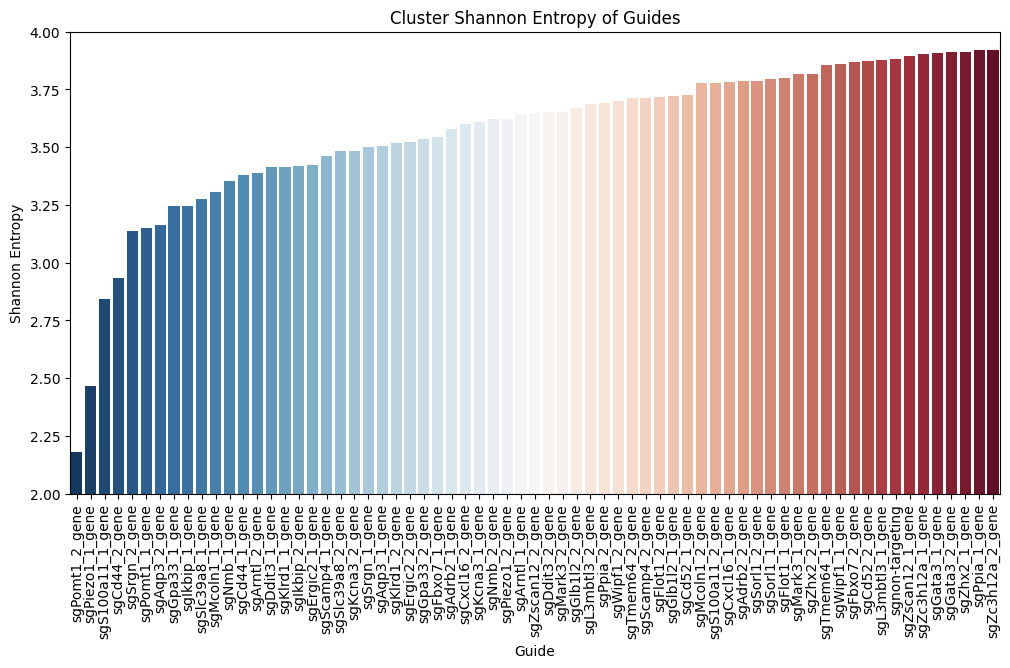

In [19]:
from scipy.stats import entropy
ent = {}
for guide in pp_df.columns:
    ent[guide] = entropy(pp_df[guide])
df = pd.DataFrame(ent, index=['Shannon Entropy']).T.reset_index().sort_values(by='Shannon Entropy')
plt.figure(figsize=(12, 6))
sns.barplot(df, x='index', y='Shannon Entropy', palette='RdBu_r')
plt.xticks(rotation=90)
plt.ylim([2.0, 4.0])
plt.title('Cluster Shannon Entropy of Guides')
plt.xlabel('Guide')

In [12]:
ntc_df = pp_df.T - pp_df.loc[:, "sgnon-targeting"]

In [13]:
pd.DataFrame(ntc_df.loc['sgCd44_2_gene'] + pp_df.loc[:, 'sgnon-targeting']).sort_index()[-12:]

0
3-2_0   0.0
3-2_1   0.0
3-2_10  0.0
3-2_11  0.0
3-2_2   0.0
3-2_3   1.0
3-2_4   0.0
3-2_5   0.0
3-2_6   0.0
3-2_7   0.0
3-2_8   0.0
3-2_9   0.0

<Figure size 640x480 with 0 Axes>

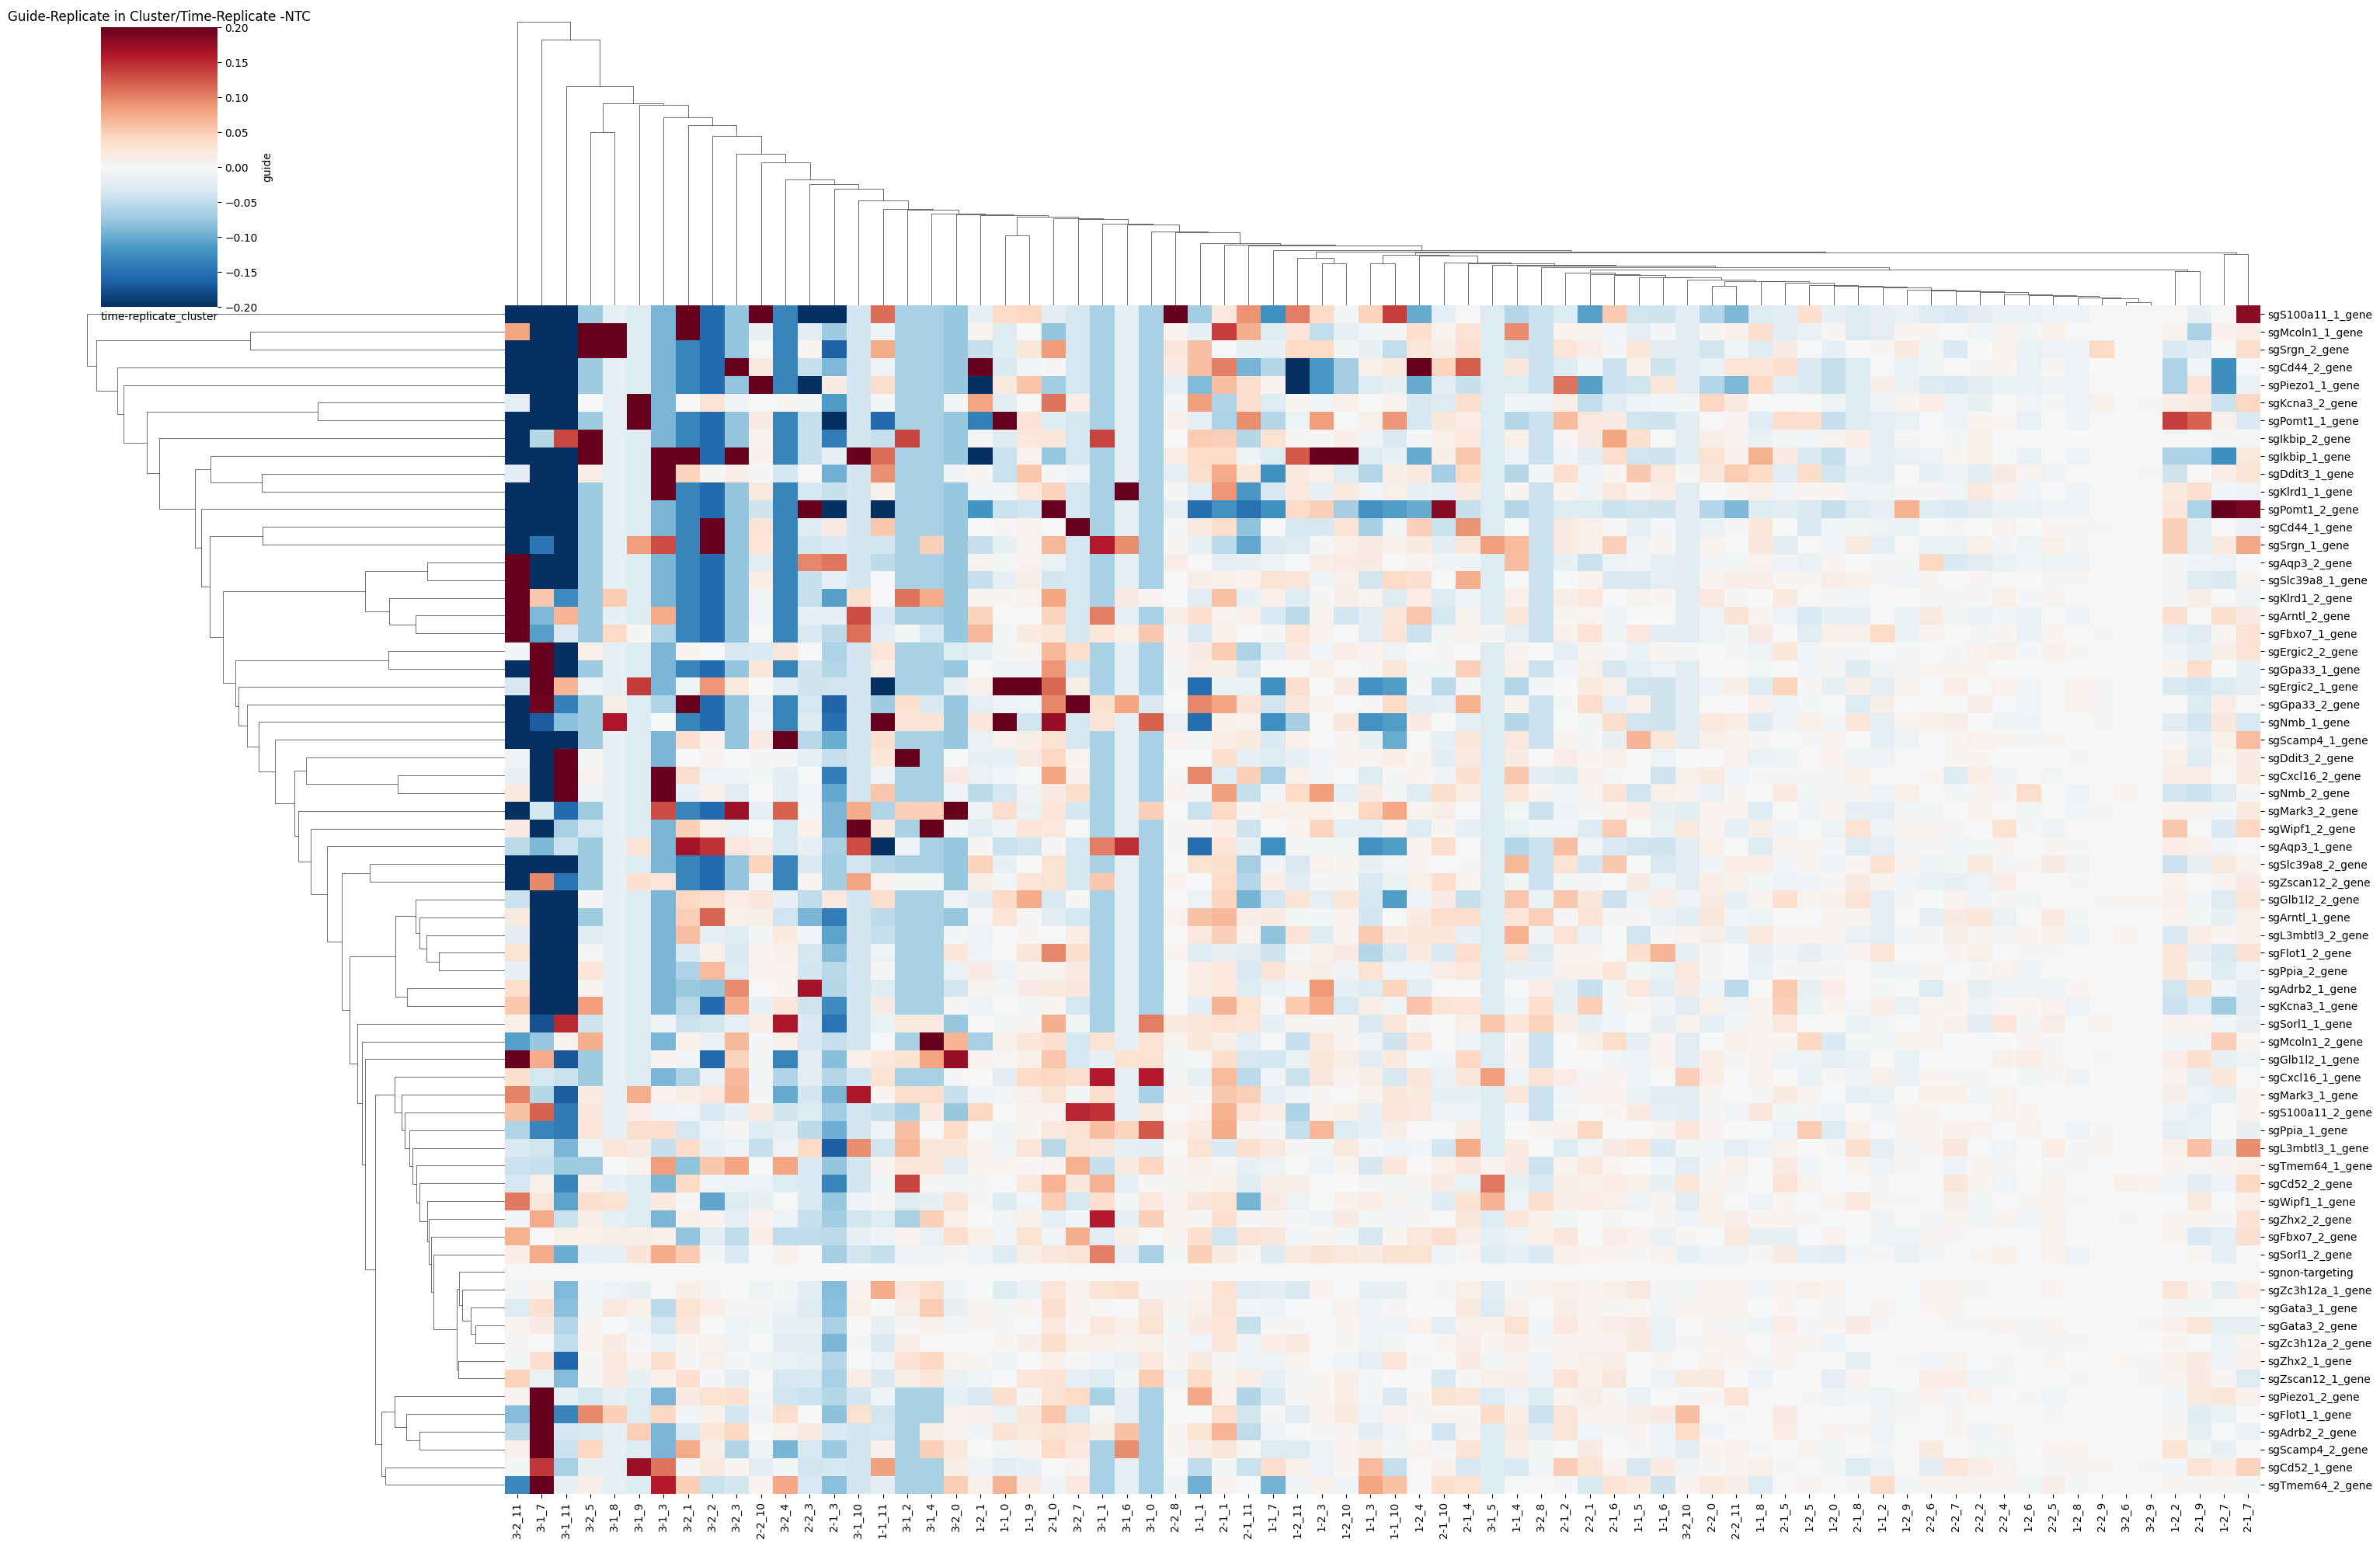

In [14]:
plt.figure()
sns.clustermap(ntc_df, cmap="RdBu_r", vmax=0.2, vmin=-0.2, figsize=(30, 20))

plt.title("Guide-Replicate in Cluster/Time-Replicate -NTC")
plt.ylabel("guide")
plt.xlabel("time-replicate_cluster")
plt.show()

In [42]:
gdata[gdata.obs.marker == '3-2', 'sgCd44_2_gene'].X.sum()

1

In [64]:
pd.DataFrame(guide_data[guide_data.obs.marker =='2-1'].X.toarray(), columns=guide_data.var_names).melt().groupby('value')

In [55]:
for marker in guide_data.obs.marker.unique():
    pd.DataFrame(guide_data[guide_data.obs.marker == marker].X)

1-1
1-2
2-1
2-2
3-1
3-2


In [24]:
c_df = pd.DataFrame(guide_data.X.toarray(), columns=guide_data.var_names)
c_df["cluster"] = guide_data.obs["cluster"].tolist()
c_df = c_df.groupby(["cluster"]).sum()

p_df = pd.DataFrame()
for guide in np.unique(c_df.columns):
    sum_v = c_df[guide].sum()
    p_v = (c_df[guide].T / sum_v).T
    p_df = pd.concat([p_df, p_v], axis=1)

p_df.columns = np.unique(c_df.columns)

ntc_df = p_df.T - p_df.loc[:, "sgnon-targeting"]

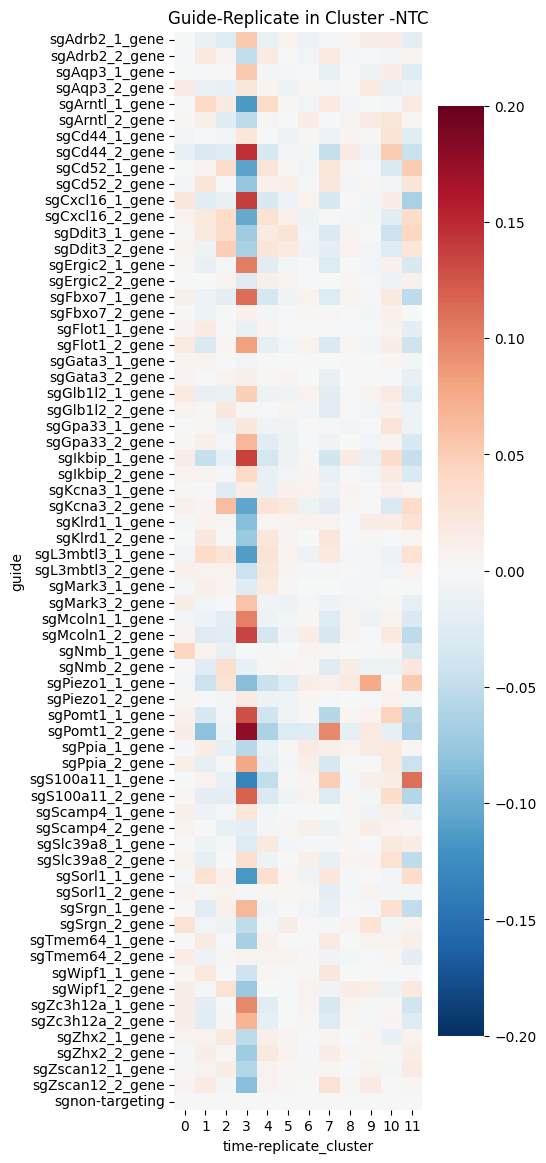

In [28]:
plt.figure(figsize=(4, 14))
sns.heatmap(ntc_df, cmap="RdBu_r", vmax=0.2, vmin=-0.2)

plt.title("Guide-Replicate in Cluster -NTC")
plt.ylabel("guide")
plt.xlabel("time-replicate_cluster")
plt.show()

In [17]:
sgs = guide_data.var_names.str.split('_', n=1).str[0]
sgs_grouped = pd.DataFrame(guide_data.X.toarray(), columns=guide_data.var_names)
sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()
sgdata = ad.AnnData(sgs_grouped, obs=guide_data.obs, var=pd.DataFrame(index=sgs_grouped.columns))
sgdata.obsm['spatial'] = guide_data.obsm['spatial']
gdata = sgdata.copy()

/tmp/ipykernel_25805/3092818934.py:3: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()


In [18]:
c_df = pd.DataFrame(gdata.X, columns=gdata.var_names)
c_df["marker"] = gdata.obs["marker"].tolist()
c_df["cluster"] = gdata.obs["cluster"].tolist()
c_df = c_df.groupby(["marker", "cluster"]).sum().unstack()

p_df = pd.DataFrame()
flag = False
for guide in np.unique(c_df.columns.get_level_values(0)):
    sum_v = c_df[guide].sum(axis=1)
    p_v = (c_df[guide].T / sum_v).T
    if not flag:
        p_df = pd.concat([p_df, p_v.reset_index().melt(id_vars="marker")], axis=1)
        flag = True
    else: p_df = pd.concat([p_df, p_v.reset_index().melt(id_vars="marker").value], axis=1)
pp_df = p_df.iloc[:, 2:]
pp_df.columns = np.unique(c_df.columns.get_level_values(0))
pp_df.index = [str(marker) + "_" + str(cluster) for marker, cluster in zip(p_df["marker"], p_df["cluster"])]

ntc_df = pp_df.T - pp_df.loc[:, "sgnon-targeting"]

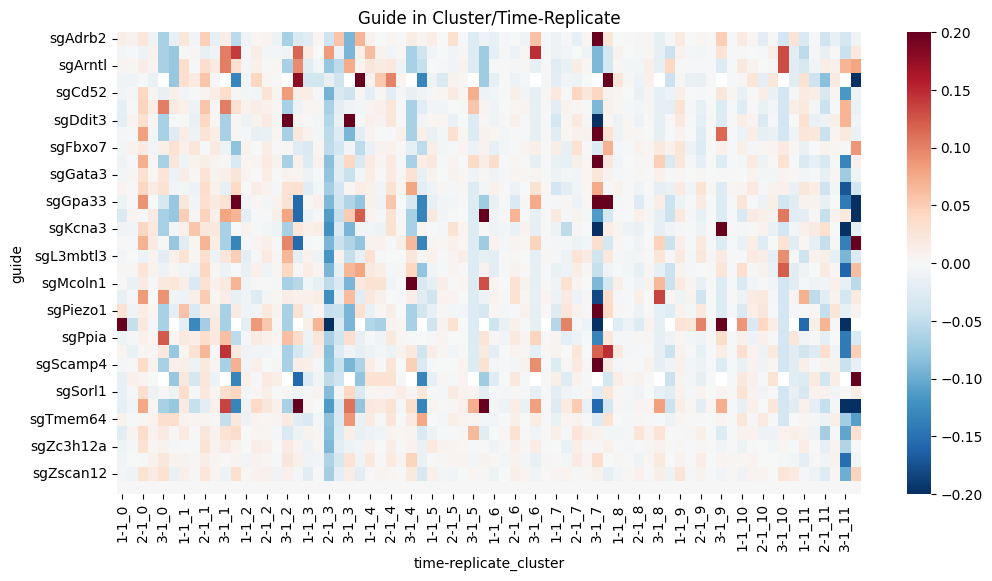

In [23]:
plt.figure(figsize=(12, 6))
sns.heatmap(ntc_df, cmap="RdBu_r", vmax=0.2, vmin=-0.2)

plt.title("Guide in Cluster/Time-Replicate")
plt.ylabel("guide")
plt.xlabel("time-replicate_cluster")
plt.show()

In [24]:
from matplotlib.gridspec import GridSpec

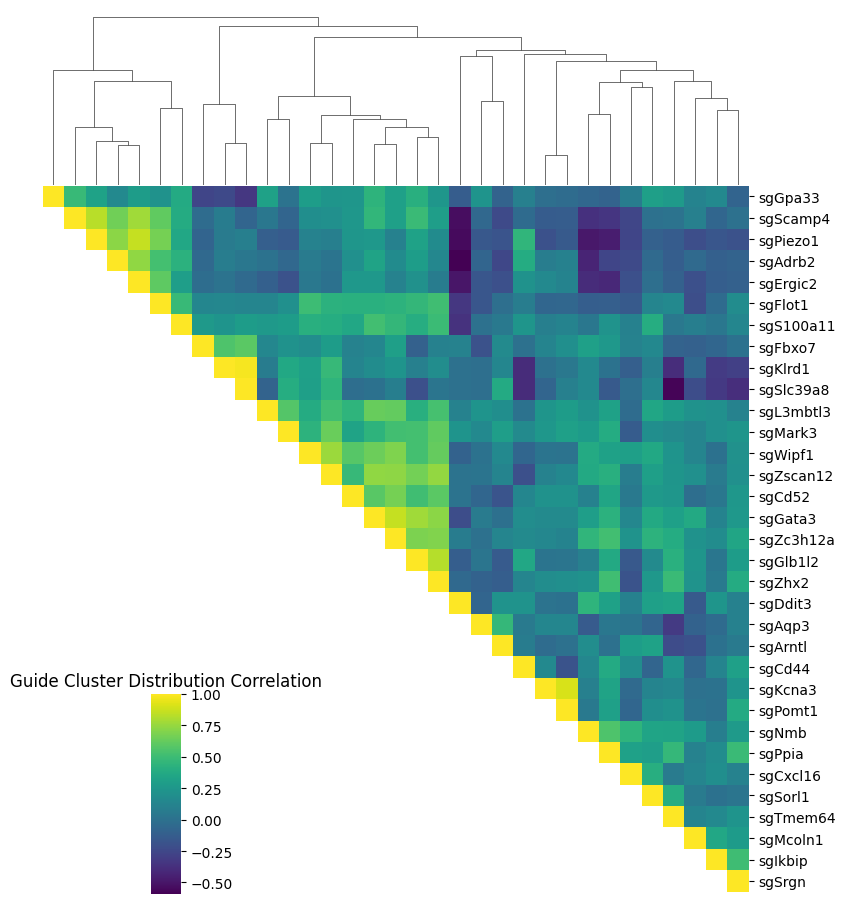

In [25]:
clean_ntc_df = ntc_df[ntc_df.index != "sgnon-targeting"]
correlation_matrix = clean_ntc_df.T.corr()

# 使用 seaborn 的 clustermap 绘制热图，并只对 x 轴进行聚类
g = sns.clustermap(correlation_matrix, cmap='viridis', figsize=(10, 10), col_cluster=True, row_cluster=True)

# 只显示右上角部分的矩阵，并保留颜色条
g.ax_row_dendrogram.set_visible(False)

# 获取聚类后的索引顺序
clustered_index = g.dendrogram_row.reordered_ind
clustered_columns = g.dendrogram_col.reordered_ind

# 创建一个新的掩码，只显示右上角部分
mask = np.zeros_like(correlation_matrix, dtype=bool)
mask[np.tril_indices_from(mask, -1)] = True

for i in range(len(mask)):
    for j in range(len(mask)):
        if mask[clustered_index[i], clustered_columns[j]]:
            g.ax_heatmap.add_patch(plt.Rectangle((clustered_columns[j], clustered_index[i]), 1, 1, fill=True, color='white', lw=0))

g.ax_heatmap.xaxis.tick_top()
g.ax_heatmap.xaxis.set_label_position('top')

g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticks(np.arange(len(correlation_matrix.index)) + 0.5)
g.ax_heatmap.set_yticklabels(correlation_matrix.index[clustered_index])

cbar = g.ax_heatmap.collections[0].colorbar
cbar.ax.set_position([0.3, 0.1, 0.03, 0.2])  # [left, bottom, width, height]

plt.title('Guide Cluster Distribution Correlation')

plt.show()

In [ ]:
r_df

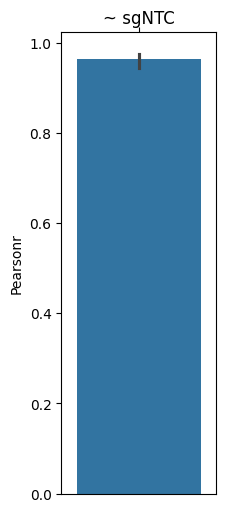

In [35]:
# calculate ntc correlation with guide
from scipy.stats import pearsonr
guide_corr = {}
for guide in gdata.var_names[gdata.var_names != "sgnon-targeting"]:
    p = pearsonr(pp_df.dropna()[guide], pp_df.dropna()["sgnon-targeting"])[0]
    guide_corr[guide] = p
r_df = pd.DataFrame(guide_corr, index=['Pearsonr'])
r_df = r_df.T.sort_values(by="Pearsonr")
plt.figure(figsize=(2, 6))
# plt.barh(r_df.columns, r_df.iloc[0], height=0.5, color="Grey")
sns.barplot(r_df, y='Pearsonr')
plt.xticks(rotation=90)
plt.title("~ sgNTC")
plt.show()

In [42]:
c_df = pd.DataFrame(gdata.X, columns=gdata.var_names)
c_df["marker"] = gdata.obs["marker"].str.split("-").str.get(0).tolist()
c_df["cluster"] = gdata.obs["cluster"].tolist()
c_df = c_df.groupby(["marker", "cluster"]).sum().unstack()

p_df = pd.DataFrame()
flag = False
for guide in np.unique(c_df.columns.get_level_values(0)):
    sum_v = c_df[guide].sum(axis=1)
    p_v = (c_df[guide].T / sum_v).T
    if not flag:
        p_df = pd.concat([p_df, p_v.reset_index().melt(id_vars="marker")], axis=1)
        flag = True
    else: p_df = pd.concat([p_df, p_v.reset_index().melt(id_vars="marker").value], axis=1)
pp_df = p_df.iloc[:, 2:]
pp_df.columns = np.unique(c_df.columns.get_level_values(0))
pp_df.index = [str(marker) + "_" + str(cluster) for marker, cluster in zip(p_df["marker"], p_df["cluster"])]

ntc_df = pp_df.T - pp_df.loc[:, "sgnon-targeting"]

<Figure size 1200x1200 with 0 Axes>

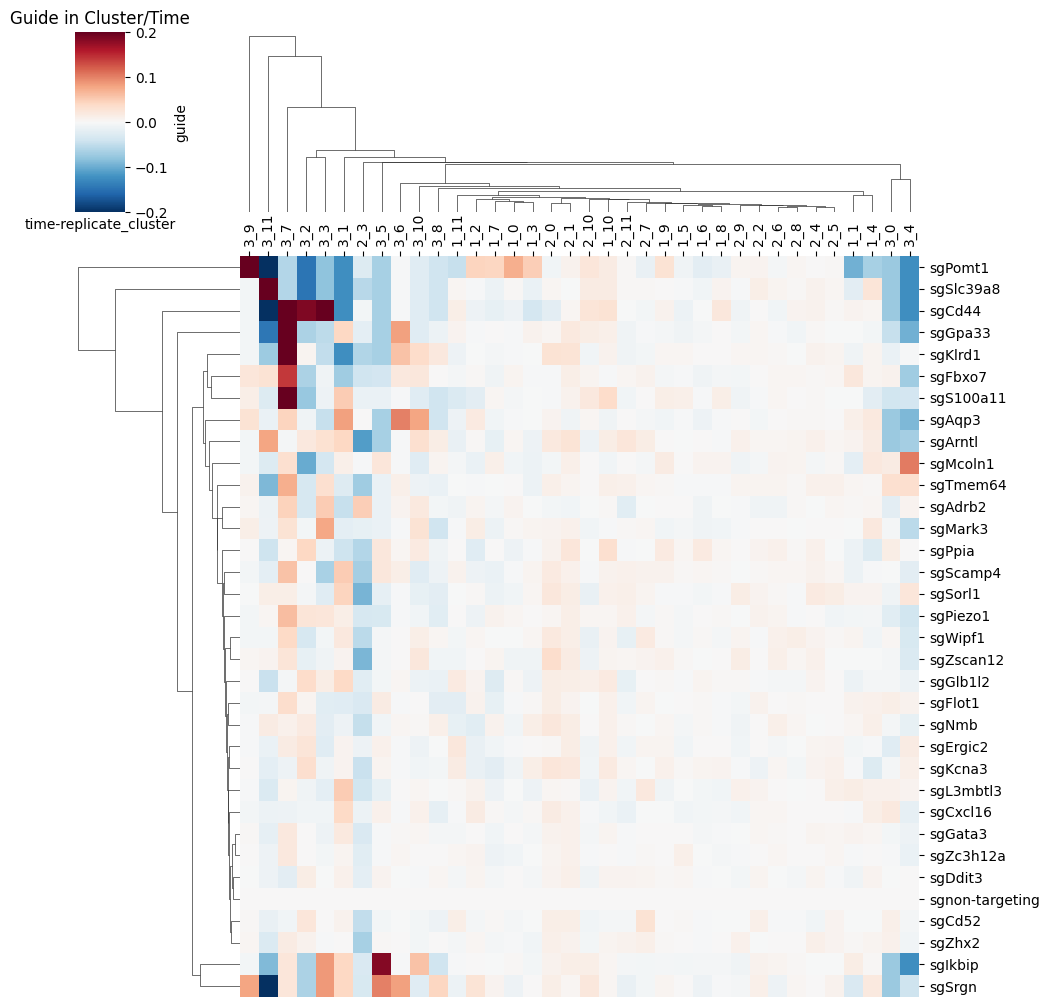

In [44]:
plt.figure(figsize=(12, 12))
sns.clustermap(ntc_df, cmap="RdBu_r", vmax=0.2, vmin=-0.2)

plt.title("Guide in Cluster/Time")
plt.ylabel("guide")
plt.xlabel("time-replicate_cluster")
plt.show()

In [118]:
p_v

cluster
0     0.102009
1     0.147638
2     0.074248
3     0.098148
4     0.065768
5     0.050803
6     0.048380
7     0.095119
8     0.048632
9     0.065970
10    0.061882
11    0.141404
Name: sgAdrb2, dtype: float64

In [84]:
old_data = sc.read_h5ad('./RNA/Multitime.guide.h5')
print(old_data.X.sum())

print(gdata.X.sum())

1613332
1613332


<Figure size 640x480 with 0 Axes>

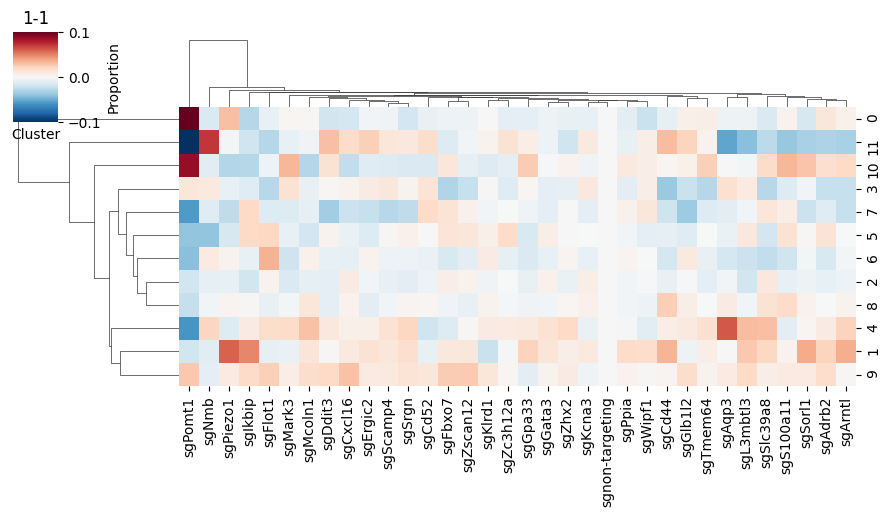

<Figure size 640x480 with 0 Axes>

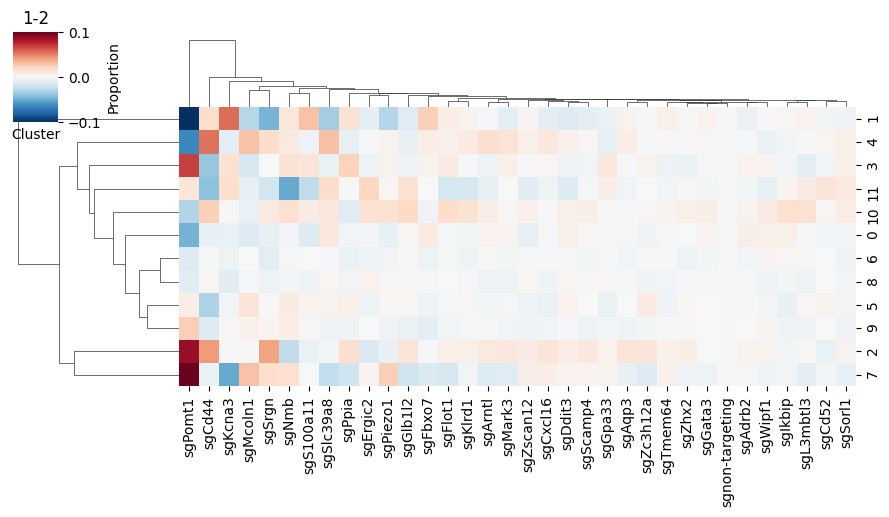

<Figure size 640x480 with 0 Axes>

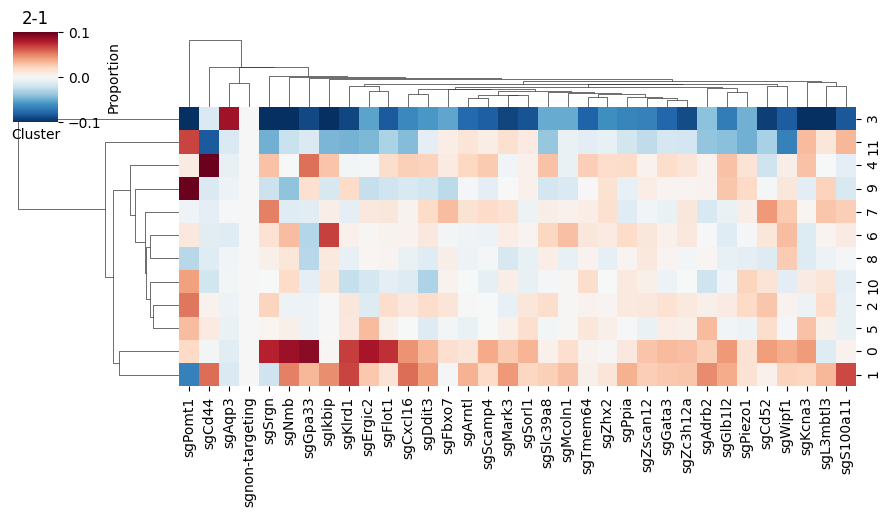

<Figure size 640x480 with 0 Axes>

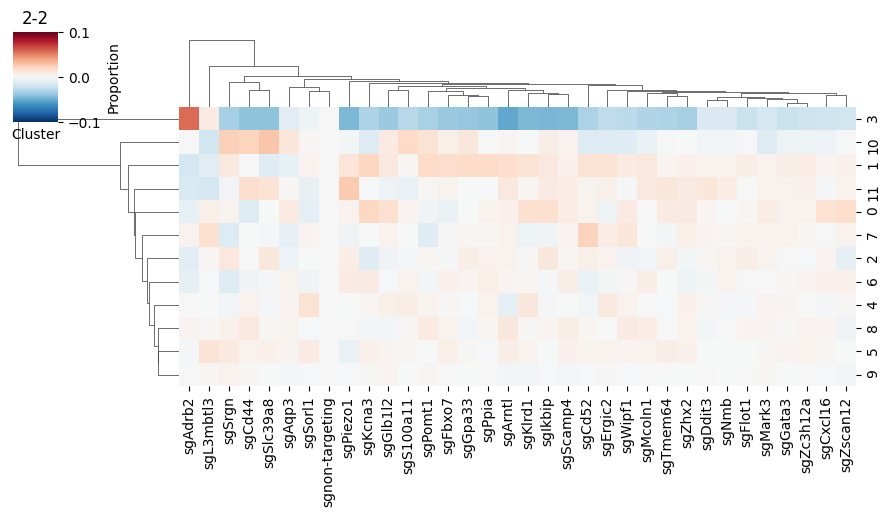

ValueError: The condensed distance matrix must contain only finite values.

<Figure size 640x480 with 0 Axes>

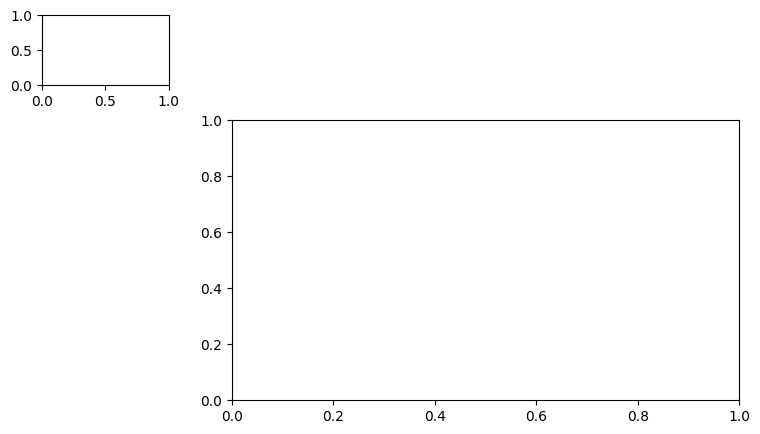

In [16]:
for marker in gdata.obs.marker.unique():
    gdata_ = gdata[gdata.obs.marker == marker].copy()
    c_df = pd.DataFrame(gdata_.X, columns=gdata_.var_names)
    c_df["cluster"] = gdata_.obs["cluster"].tolist()
    c_df = c_df.groupby(["cluster"]).sum()

    p_df = pd.DataFrame()
    for guide in np.unique(c_df.columns):
        sum_v = c_df[guide].sum()
        p_v = (c_df[guide].T / sum_v).T
        p_df = pd.concat([p_df, p_v], axis=1)

    p_df.columns = np.unique(c_df.columns)

    ntc_df = p_df.T - p_df.loc[:, "sgnon-targeting"]

    plt.figure()
    sns.clustermap(ntc_df.T, cmap="RdBu_r", vmax=0.1, figsize=(9, 5), vmin=-0.1)
    plt.colorbar.label = 'str'

    plt.title(f"{marker}")
    plt.ylabel("Proportion")
    plt.xlabel("Cluster")
    plt.show()

In [29]:
c_df = pd.DataFrame(gdata.X, columns=gdata.var_names)
c_df["cluster"] = gdata.obs["cluster"].tolist()
c_df = c_df.groupby(["cluster"]).sum()

p_df = pd.DataFrame()
for guide in np.unique(c_df.columns):
    sum_v = c_df[guide].sum()
    p_v = (c_df[guide].T / sum_v).T
    p_df = pd.concat([p_df, p_v], axis=1)

p_df.columns = np.unique(c_df.columns)

ntc_df = p_df.T - p_df.loc[:, "sgnon-targeting"]

<Figure size 640x480 with 0 Axes>

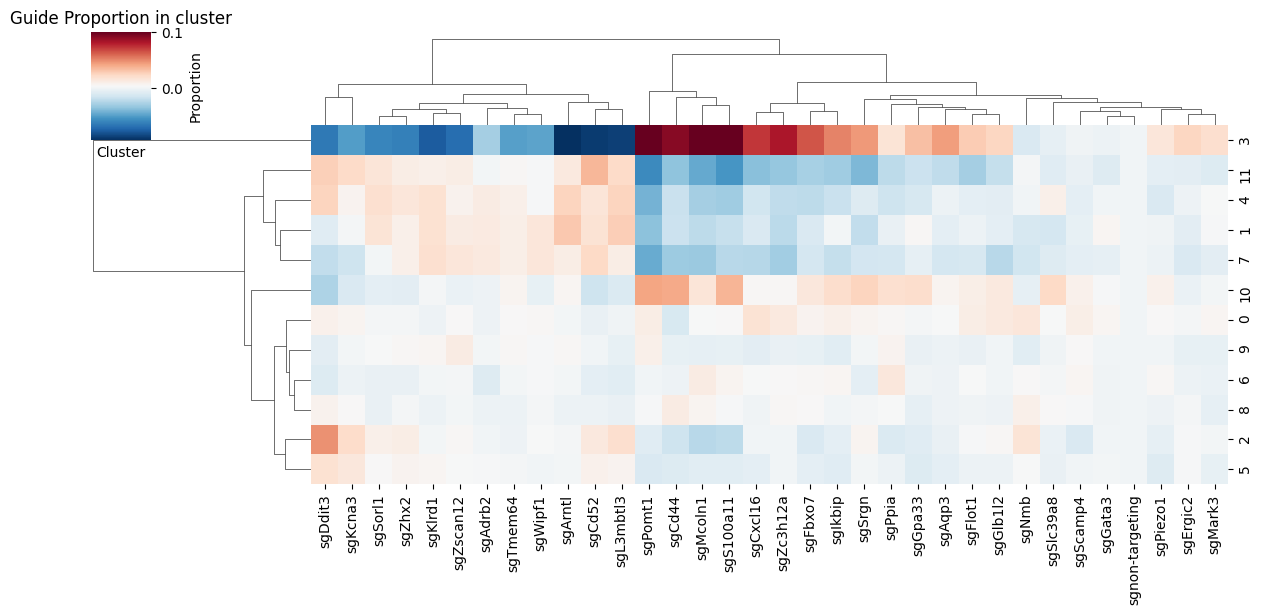

In [57]:
plt.figure()
sns.clustermap(ntc_df.T, cmap="RdBu_r", vmax=0.1, figsize=(12, 6))
plt.colorbar.label = 'str'

plt.title("Guide Proportion in cluster")
plt.ylabel("Proportion")
plt.xlabel("Cluster")
plt.show()

<Figure size 1200x600 with 0 Axes>

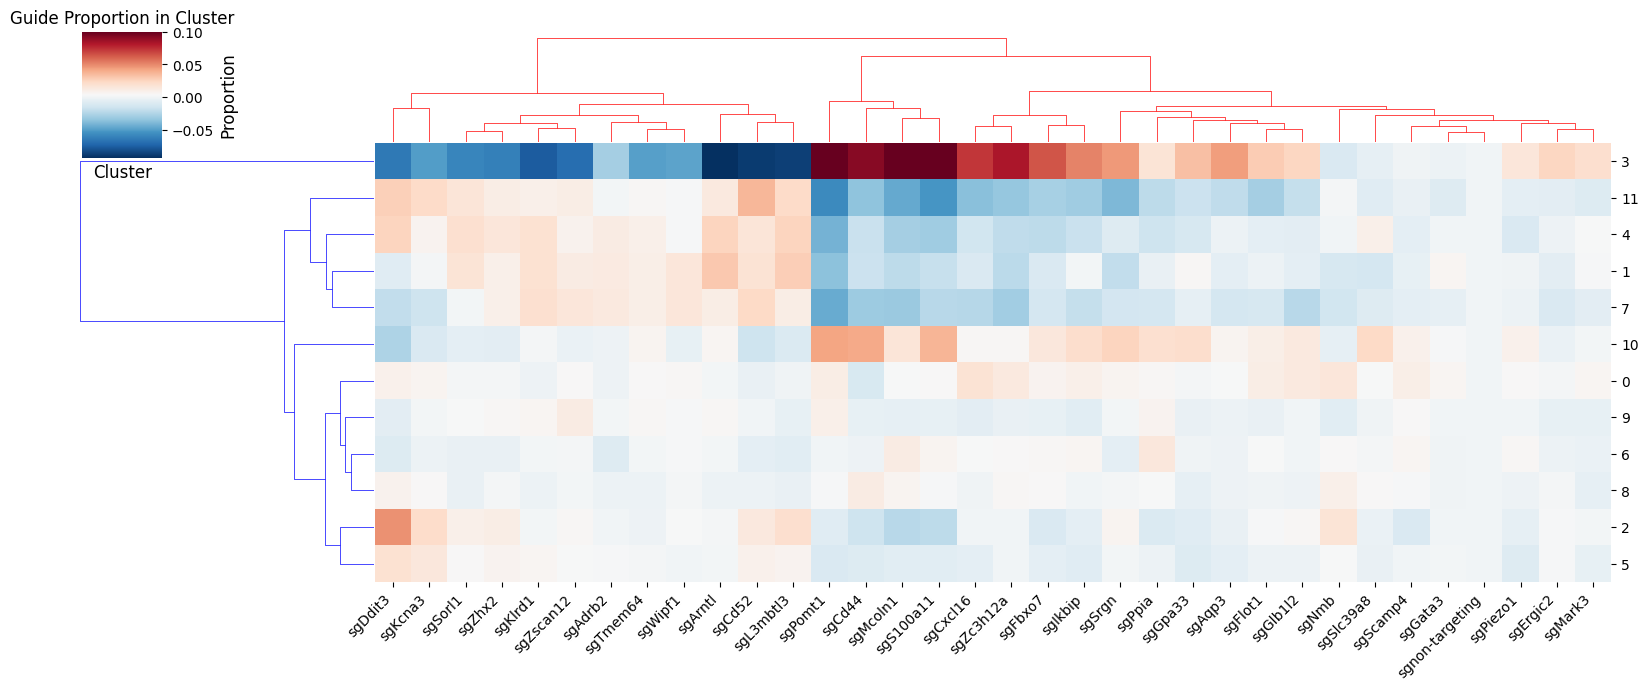

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data
# ntc_df = pd.DataFrame(...)  # Assume ntc_df is already defined

# Create the clustermap
plt.figure(figsize=(12, 6))
clustermap = sns.clustermap(ntc_df.T, cmap="RdBu_r", vmax=0.1, figsize=(16, 7))

# Customize the appearance
# Change the color of the dendrogram
for i, line in enumerate(clustermap.ax_col_dendrogram.collections):
    line.set_color('red')  # Change to your preferred color

for i, line in enumerate(clustermap.ax_row_dendrogram.collections):
    line.set_color('blue')  # Change to your preferred color

# Rotate x and y tick labels
clustermap.ax_heatmap.set_xticklabels(clustermap.ax_heatmap.get_xticklabels(), rotation=45, ha='right')
clustermap.ax_heatmap.set_yticklabels(clustermap.ax_heatmap.get_yticklabels(), rotation=0)

# Set the colorbar title
colorbar = clustermap.ax_heatmap.collections[0].colorbar
colorbar.set_label('Guide Proportion')

# Set titles and labels
plt.title("Guide Proportion in Cluster", fontsize=12)
plt.ylabel("Proportion", fontsize=12)
plt.xlabel("Cluster", fontsize=12)

# Show the plot
plt.show()


# Guide Correlation

In [10]:
sgs = guide_data.var_names.str.split('_', n=1).str[0]
sgs_grouped = pd.DataFrame(guide_data.X.toarray(), columns=guide_data.var_names)
sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()
sgdata = ad.AnnData(sgs_grouped, obs=guide_data.obs, var=pd.DataFrame(index=sgs_grouped.columns))
sgdata.obsm['spatial'] = guide_data.obsm['spatial']
gdata = sgdata.copy()

/tmp/ipykernel_25805/3092818934.py:3: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()


In [16]:
from scipy.stats import spearmanr
from scipy.stats import pearsonr

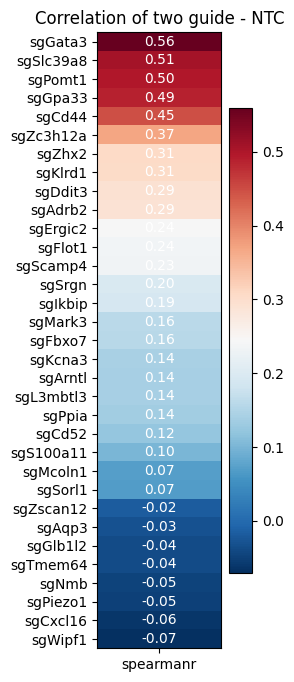

In [28]:
p_df = {}
do_df = ntc_df
for guide in gdata.var_names:
    if guide != "sgnon-targeting":
        p = spearmanr(do_df.loc[:, guide + "_1_gene"], do_df.loc[:, guide + "_2_gene"])[0]
        p_ = pearsonr(do_df.loc[:, guide + "_1_gene"], do_df.loc[:, guide + "_2_gene"])[0]
        p_df[guide] = {
            "spearmanr": p,
            # "pearsonr": p_
        }
p_df = pd.DataFrame(p_df).T.sort_values(by='spearmanr', ascending=False)
plt.figure(figsize=(2, 8))
plt.imshow(p_df, cmap='RdBu_r', aspect='auto')

plt.colorbar()
plt.xticks(np.arange(p_df.shape[1]), p_df.columns)
plt.yticks(np.arange(p_df.shape[0]), p_df.index)

# 在每个单元格中标注数据
for i in range(p_df.shape[0]):
    for j in range(p_df.shape[1]):
        plt.text(j, i, f'{p_df.iloc[i, j]:.2f}', ha='center', va='center', color='white')

plt.title('Correlation of two guide - NTC')
plt.show()